## Telescope with constant uvgap?

$\frac{\Delta u}{u} \equiv const.$

This should be true for a long spiral with baselines only to the central antenna

see:
http://arxiv.org/pdf/1001.1477v1.pdf

In [ ]:
from __future__ import print_function, division, absolute_import
from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pyuvwsim import (evaluate_baseline_uvw_ha_dec, 
                      evaluate_station_uvw_ha_dec,
                      convert_enu_to_ecef)
from math import radians, degrees, pi, ceil, sin, asin, log, log10
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# plt.style.use('ggplot')
# plt.xkcd()
# plt.style.use('default')
import seaborn
seaborn.set()
# seaborn.set(style="ticks")
seaborn.set_style('ticks', {'xtick.major.size': 5, 'ytick.major.size': 5})
seaborn.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})

In [10]:
class Test(object):
    def __init__(self):
        self.button = widgets.Button(description='go!')
        self.button.on_click(self.show)
        self.slider = widgets.IntSlider(min=1, max=10)
        display(widgets.HBox((self.slider, self.button)))
        
    def show(self, ev=None):
        clear_output()
        print(self.slider.value)

test = Test()
        
#import ipywidgets
#ipywidgets?
#from ipywidgets import IntSlider, Button
# slider = widgets.IntSlider(min=1, max=10)
# button = widgets.Button(description='go')
# display(slider, button)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [11]:
# Settings
# http://www.vla.nrao.edu/genpub/overview/
lat = radians(90.0)  
lon = radians(0.0)
dec = lat
ha_min = -6
ha_max = +6
dump_time = 10 # min
duration = ha_max - ha_min
num_times = 1 if duration * 60 < dump_time \
    else ((duration) * 60) // dump_time  # 1 sample every 10 min
freq_hz = 1000.0e6
oversampling = 2.4
dish_d = 25.0
res_n = 10
res_bmin = None
res_bmax = None

radius range: 50.000, 2000.000 m


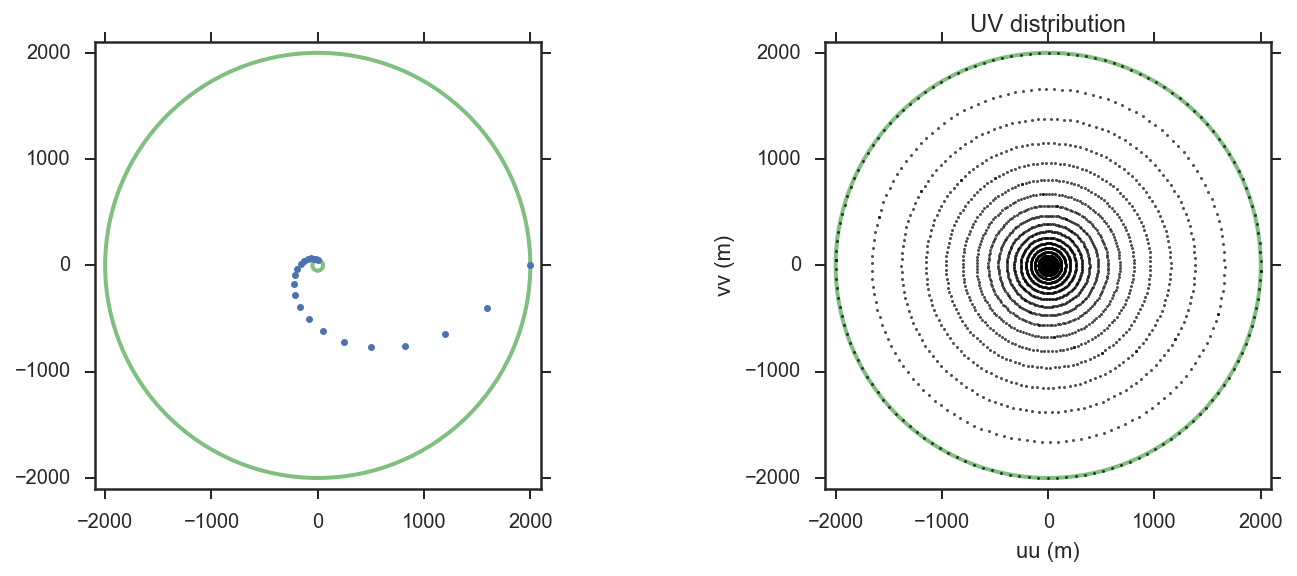

In [14]:
# Generate ENU coordinates and convert to ECEF
r_min, r_max = 50.0, 2000.0
b = log(r_max/r_min)/radians(270.0)
print('b', b)

@interact(r_min=(0, 1000, 5.0), r_max=(500.0, 5000.0, 50),
         b=(0.0, 20.0, 0.05), n=(1, 200, 1))
def log_spiral_2(r_min=r_min, r_max=r_max, b=b, n=20):
    theta_max = log(r_max / r_min) * (1.0 / b)
    t = np.linspace(0.0, theta_max, n)
    tmp = r_min * np.exp(b * t)
    xe, yn = tmp * np.cos(t), tmp * np.sin(t)
    n = xe.shape[0]
    r_enu = (xe**2 + yn**2)**0.5
    r_min, r_max = r_enu.min(), r_enu.max()
    print('radius range: %.3f, %.3f m' % (r_min, r_max))

    zu = np.zeros_like(xe)
    x, y, z = convert_enu_to_ecef(xe, yn, zu, lon, lat)

    # Generate UV coordinates
    uu, vv, ww = np.array([]), np.array([]), np.array([])
    b_id = np.array([], dtype='i8')
    ha1_rad = (ha_min / 24) * (2 * pi)
    ha2_rad = (ha_max / 24) * (2 * pi)
    for i, ha in enumerate(np.linspace(ha1_rad, ha2_rad, num_times)):
        u_, v_, w_ = evaluate_station_uvw_ha_dec(x, y, z, ha - lon, dec)
        uu_, vv_, ww_ = u_[1:] - u_[0], v_[1:] - v_[0], w_[1:] - w_[0]
        uu, vv, ww = np.append(uu, uu_), np.append(vv, vv_), np.append(ww, ww_)
        b_id = np.append(b_id, (range(u_.shape[0] - 1)))

    fig = plt.figure(figsize=(12, 4))
    # Layout plot
    ax = fig.add_subplot(121, aspect='equal')
    ax.plot(x, y, '.')
    c = plt.Circle((0.0, 0.0), r_min, fill=False, color='g', linestyle='-', 
                   linewidth=2.0, alpha=0.5)
    ax.add_artist(c)     
    c = plt.Circle((0.0, 0.0), r_max, fill=False, color='g', linestyle='-',
                   linewidth=2.0, alpha=0.5)
    ax.add_artist(c)     
    ax.set_xlim(-r_max*1.05, r_max*1.05)
    ax.set_ylim(-r_max*1.05, r_max*1.05)

    # uv scatter plot
    ax = fig.add_subplot(122, aspect='equal')
    ax.plot(uu, vv, '.', color='k', ms=3.0, alpha=0.7)
    ax.plot(-uu, -vv, '.', color='k', ms=3.0, alpha=0.7)
    rc = (uu**2 + vv**2)**0.5
    rc0, rc1 = rc.min(), rc.max()
    c = plt.Circle((0.0, 0.0), rc1, fill=False, color='g',
                       linestyle='-', linewidth=2.0, alpha=0.5)
    ax.add_artist(c)
    ax.set_xlim(-rc1*1.05, rc1*1.05)
    ax.set_ylim(-rc1*1.05, rc1*1.05)
    ax.set_xlabel('uu (m)')
    ax.set_ylabel('vv (m)')
    ax.set_title('UV distribution')
    plt.show()
    return uu, vv

In [15]:
# Convert to r, theta
uu_ = np.copy(uu)
vv_ = np.copy(vv)
r = (uu_**2 + vv_**2)**0.5
theta = np.arctan2(vv_, uu_)
theta[theta < 0.0] += pi
order = np.argsort(r)
r = r[order]
theta = theta[order]

NameError: name 'uu' is not defined

In [7]:
print('Predicted uvgap: %.3f' % ((rc1/rc0)**(1/n)-1))

# Define bin edges
b0 = r.min() if not res_bmin else res_bmin
b1 = r.max() if not res_bmax else res_bmax
r_edges = np.logspace(log10(b0), log10(b1), res_n + 1)
theta_edges = np.linspace(0, pi, res_n + 1)
theta_idx = np.digitize(theta, theta_edges)
uv_gap_im = np.zeros((res_n, res_n))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

# Loop over theta bins
for j in range(res_n):
    r_bin_all = r[theta_idx == 1 + j]
    b_bin_all = b_id[theta_idx == 1 + j]
    r_bin = np.array([])    
    for b in np.unique(b_bin_all):
        r_bin = np.append(r_bin, np.mean(r_bin_all[np.where(b_bin_all == b)]))

    r_bin = np.append(r_bin, 0.0)
    r_bin = np.sort(r_bin)
    r_diff = np.diff(r_bin)

    if j == 0:
        np.set_printoptions(precision=2)
        print(r_bin)
        print(r_diff)
        
    r_diff_norm = r_diff / r_bin[1:]
        
    # Loop over r bins
    for i in range(res_n):
#         i0 = np.where(r_bin <= r_edges[i])[0][-1]
#         i1 = np.where(r_bin > r_edges[i + 1])[0]
#         i1 = r_bin.shape[0] - 1 if len(i1) == 0 else i1[0]
#         bin_diffs = r_diff_norm[:i1-1]
        i1 = np.where(r_bin <= r_edges[i + 1])[0][-1]
        bin_diffs = r_diff_norm[:i1]
        
        if i == 4:
            ax.plot([r_edges[i + 1], r_edges[i + 1]], [-1, res_n+1], '-', 
                    color='g', lw=4.0, alpha=0.1)
            ax.plot([r_edges[i], r_edges[i]], [-1, res_n+1], '-', 
                    color='c', lw=20.0, alpha=0.03)
#             np.set_printoptions(precision=2)
#             print(j, i, '-', i1, bin_diffs)
#             for p in range(i1+1):
#                 ax.text(r_bin[p] + r_diff[p] / 2, j, '%.2f' % r_diff_norm[p],
#                        va='center', ha='center', fontsize='x-small', 
#                         weight='bold')

        uv_gap_im[j, i] = numpy.nanmean(bin_diffs) \
            if bin_diffs.shape[0] > 0 else 1.0                       
        ax.plot(r_bin, np.zeros_like(r_bin) + j, 'r.', ms=5.0)
        ax.plot([0, 3500], [j, j], 'k-', alpha=0.05)
    
ax.plot([r_edges[0], r_edges[0]], ax.get_ylim(), 'k--', alpha=0.5)   
for i in range(1, res_n + 1):
    ax.plot([r_edges[i], r_edges[i]], ax.get_ylim(), 'k-', alpha=0.5)   
    
ax.set_xlim(-10, r_edges[6])
ax.set_ylim(-1, res_n)
plt.show()

# Convert to radial profile
uv_gap_r_1 = np.zeros(res_n)

for i in range(res_n):
    uv_gap_r_1[i] = np.mean(uv_gap_im[:, i])
    
for i in range(5):
    print('%2i : %7.2f %8.5f' % (i + 1, r_edges[i + 1], uv_gap_r_1[i]))

NameError: name 'rc1' is not defined

In [ ]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(r_edges[1:], uv_gap_r_1, '.-', color='r', ms=10.0, label='notebook')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc=3)
plt.show()

In [6]:
from ipywidgets.widgets import interact

@interact(fun=('a', 'b', 'c'), 
          filename='foo',
          x=(0, 1000, 5), 
          y=(-5.0, 20.0, 0.001),
          plot=True
         )
def f(fun, filename, plot, x=0, y=0.0):
    print(fun, filename, x, y, plot)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


a foo 0 0.0 True


In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display
from time import sleep
f = FloatProgress(min=0, max=100)
display(f)

for i in xrange(100):
   sleep(0.1)
   f.value = i